In [14]:
import numpy as np
import rasterio as rio
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
from cartopy.feature import ShapelyFeature
import matplotlib.patches as mpatches
import os
print(os.getcwd())

C:\GIS_course\Modules\EGM722\EGM722_clone\egm722\Week4


In [15]:
def percentile_stretch(img, pmin=0., pmax=100.):
    '''
    This is where you should write a docstring.
    '''
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    # here, we make sure that the image is only 2-dimensional
    if not img.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')

    minval = np.percentile(img, pmin)
    maxval = np.percentile(img, pmax)

    stretched = (img - minval) / (maxval - minval)  # stretch the image to 0, 1
    stretched[img < minval] = 0  # set anything less than minval to the new minimum, 0.
    stretched[img > maxval] = 1  # set anything greater than maxval to the new maximum, 1.

    return stretched

In [16]:
def img_display(img, ax, bands, stretch_args=None, **imshow_args):
    '''
    This is where you should write a docstring.
    '''
    dispimg = img.copy().astype(np.float32)  # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(img.shape[0]):  # loop over each band, stretching using percentile_stretch()
        if stretch_args is None:  # if stretch_args is None, use the default values for percentile_stretch
            dispimg[b] = percentile_stretch(img[b])
        else:
            dispimg[b] = percentile_stretch(img[b], **stretch_args)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])

    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], **imshow_args)

    return handle, ax


In [17]:
# ------------------------------------------------------------------------
# note - rasterio's open() function works in much the same way as python's - once we open a file,
# we have to make sure to close it. One easy way to do this in a script is by using the with statement shown
# below - once we get to the end of this statement, the file is closed.
with rio.open('C:/GIS_course/Modules/EGM722/EGM722_clone/egm722/Week4/data_files/NI_Mosaic.tif') as dataset:
    img = dataset.read()
    xmin, ymin, xmax, ymax = dataset.bounds

In [18]:
# your code goes here!
# start by loading the outlines and point data to add to the map
outline = gpd.read_file(os.path.abspath('C:/GIS_course/Modules/EGM722/EGM722_clone/egm722/Week2/data_files/NI_outline.shp'))
towns = gpd.read_file(os.path.abspath("C:/GIS_course/Modules/EGM722/EGM722_clone/egm722/Week2/data_files/Towns.shp"))
counties = gpd.read_file(os.path.abspath("C:/GIS_course/Modules/EGM722/EGM722_clone/egm722/Week2/data_files/Counties.shp"))

towns.crs
counties.crs

<Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
ni_utm = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.

In [20]:
ccrs.CRS(outline.crs) # create a cartopy CRS representation of the CRS associated with the outline dataset

<Projected CRS: EPSG:32629>
Name: WGS 84 / UTM zone 29N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°W and 6°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Côte D'Ivoire (Ivory Coast). Faroe Islands. Guinea. Ireland. Jan Mayen. Liberia, Mali. Mauritania. Morocco. Portugal. Sierra Leone. Spain. United Kingdom (UK). Western Sahara.
- bounds: (-12.01, 0.0, -6.0, 84.01)
Coordinate Operation:
- name: UTM zone 29N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
print(f"{dataset.name} opened in {dataset.mode} mode")
print(f"image has {dataset.count} band(s)")
print(f"image size (width, height): {dataset.width} x {dataset.height}")
print(f"band 1 dataype is {dataset.dtypes[0]}") # note that the band name (Band 1) differs from the list index [0]
print(dataset.bounds)
print(dataset.crs)

C:/GIS_course/Modules/EGM722/EGM722_clone/egm722/Week4/data_files/NI_Mosaic.tif opened in r mode
image has 7 band(s)
image size (width, height): 1850 x 1500
band 1 dataype is int16
BoundingBox(left=550000.0, bottom=5985000.0, right=735000.0, top=6135000.0)
EPSG:32629


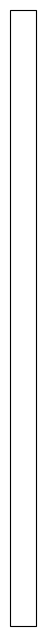

In [22]:
# next, create the figure and axis objects to add the map to
fig = plt.figure(figsize=(8, 8))  # create a figure of size 8x8 (representing the page size in inches)
ax = plt.axes(projection=ni_utm)  # create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.
# fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=ni_utm))

In [23]:
print(img.shape)

(7, 1500, 1850)


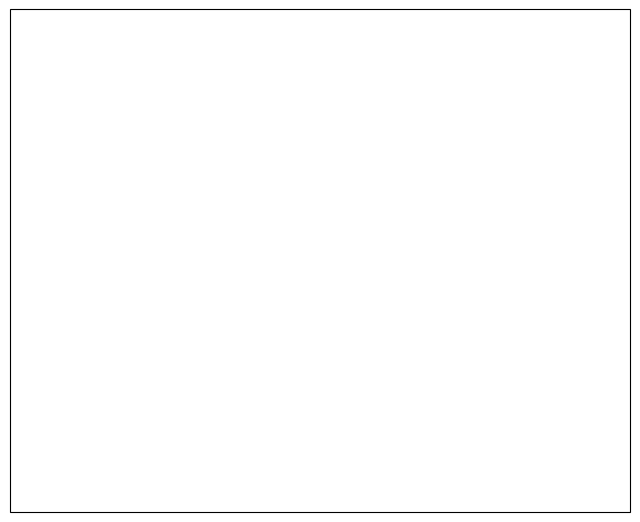

In [24]:
# now, add the satellite image to the map
ax.imshow(img[3], cmap='gray', vmin=200, vmax=5000) # display band 4 as a grayscale image, stretched between 200 and 5000
ax.set_extent([xmin, xmax, ymin, ymax], crs=ni_utm) # set the extent to the image boundary

fig # show the figure

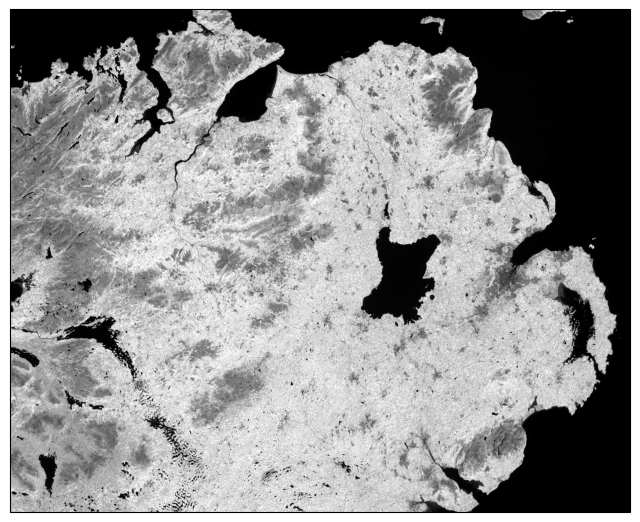

In [25]:
ax.imshow(img[3], cmap='gray', vmin=200, vmax=5000, transform=ni_utm, extent=[xmin, xmax, ymin, ymax])
ax.set_extent([xmin, xmax, ymin, ymax], crs=ni_utm) # set the extent to the image boundary

fig

In [31]:
ax.imshow(img[0:3], transform=ni_utm, extent=[xmin, xmax, ymin, ymax])

fig

TypeError: Invalid shape (3, 1500, 1850) for image data

In [32]:
def img_display(image, ax, bands, transform, extent):
    '''
    This is where you should write a docstring.
    '''
    # first, we transpose the image to re-order the indices
    dispimg = image.transpose([1, 2, 0])
    
    # next, we have to scale the image.
    dispimg = dispimg / dispimg.max()
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], transform=transform, extent=extent)
    
    return handle, ax

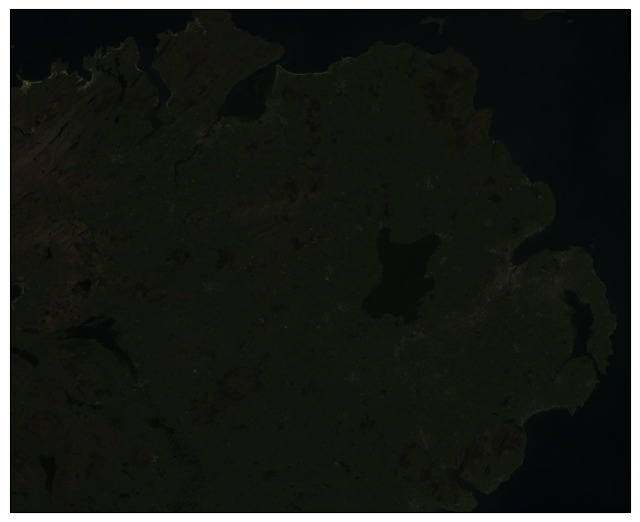

In [33]:
h, ax = img_display(img, ax, [2, 1, 0], ni_utm, [xmin, xmax, ymin, ymax])
fig # just to save you from scrolling back up to see

In [34]:
maxvals = [img[ind].max() for ind in range(dataset.count)]
print(maxvals)

[np.int16(2574), np.int16(3473), np.int16(4110), np.int16(6309), np.int16(8659), np.int16(3010), np.int16(6127)]


In [35]:
def percentile_stretch(image, pmin=0., pmax=100.):
    '''
    This is where you should write a docstring.
    '''
    # here, we make sure that pmin < pmax, and that they are between 0, 100
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    # here, we make sure that the image is only 2-dimensional
    if not image.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')
    
    minval = np.percentile(image, pmin)
    maxval = np.percentile(image, pmax)
    
    stretched = (image - minval) / (maxval - minval) # stretch the image to 0, 1
    stretched[image < minval] = 0 # set anything less than minval to the new minimum, 0.
    stretched[image > maxval] = 1 # set anything greater than maxval to the new maximum, 1.
    
    return stretched

In [36]:
def img_display(image, ax, bands, transform, extent, pmin=0, pmax=100):
    '''
    This is where you should write a docstring.
    '''
    dispimg = image.copy().astype(np.float32) # make a copy of the original image,
    # but be sure to cast it as a floating-point image, rather than an integer

    for b in range(image.shape[0]): # loop over each band, stretching using percentile_stretch()
        dispimg[b] = percentile_stretch(image[b], pmin=pmin, pmax=pmax)

    # next, we transpose the image to re-order the indices
    dispimg = dispimg.transpose([1, 2, 0])
    
    # finally, we display the image
    handle = ax.imshow(dispimg[:, :, bands], transform=transform, extent=extent)
    
    return handle, ax

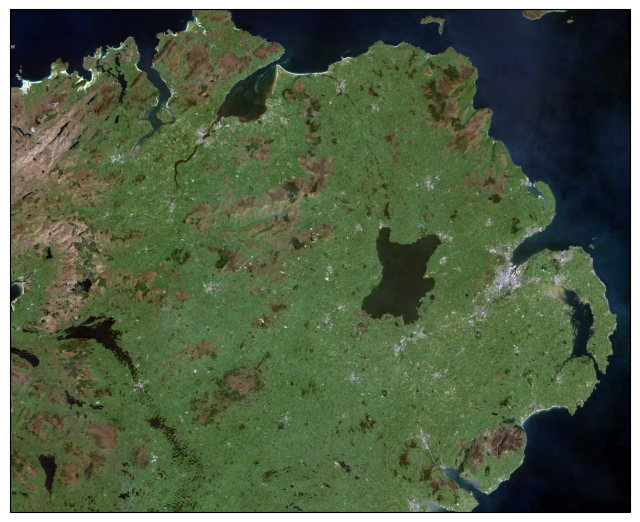

In [37]:
h, ax = img_display(img, ax, [2, 1, 0], ni_utm, [xmin, xmax, ymin, ymax], pmin=0.1, pmax=99.9)
fig # just to save you from scrolling back up to see

In [38]:
# write your code here!

In [39]:
counties = counties.to_crs('epsg: 32629') # reproject counties to epsg: 32629
counties.crs

<Projected CRS: EPSG:32629>
Name: WGS 84 / UTM zone 29N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 12°W and 6°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Côte D'Ivoire (Ivory Coast). Faroe Islands. Guinea. Ireland. Jan Mayen. Liberia, Mali. Mauritania. Morocco. Portugal. Sierra Leone. Spain. United Kingdom (UK). Western Sahara.
- bounds: (-12.01, 0.0, -6.0, 84.01)
Coordinate Operation:
- name: UTM zone 29N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

C:\Users\byg-l\anaconda\envs\egm722\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


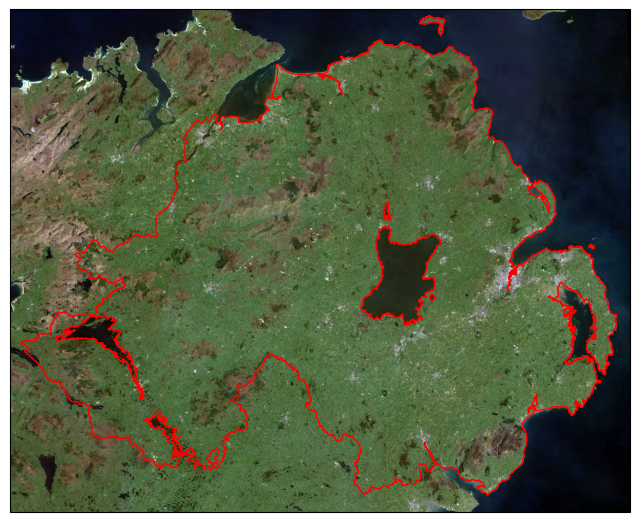

In [40]:
# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], ni_utm, edgecolor='r', facecolor='none')
ax.add_feature(outline_feature) # add the features we've created to the map.

# next, add the county outlines to the map
# choose colours for county boundaries
county_colors = ['violet', 'slateblue', 'skyblue', 'mediumseagreen', 'orange', 'lightcoral']

# get a list of unique names for the county boundaries
county_names = list(counties.CountyName.unique())
county_names.sort() # sort the counties alphabetically by name

# next, add the municipal outlines to the map using the colors that we've picked.
# here, we're iterating over the unique values in the 'CountyName' field.
for ii, name in enumerate(county_names):
    counties_feature = ShapelyFeature(counties.loc[counties['CountyName'] == name, 'geometry'], # first argument is the geometry
                         # ni_utm, second argument is the CRS
                          ccrs.CRS(counties.crs), 
                          edgecolor='r', # outline the feature in red
                          facecolor='none', # set face colour to not show
                          linewidth=1, # set the outline width to be 1 pt
                          alpha=0) # set the alpha (transparency) to be 0 (out of 1)
    ax.add_feature(counties_feature) # add feature to map

fig # to show the updated figure

In [41]:
# then, add the town and city points to the map, but separately
towns.crs 

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [42]:
towns.head()

TOWN_NAME  X_COORD  Y_COORD STATUS  town_city                   geometry
0   Strabane   234500   397700   Town          0  POINT (-7.46398 54.82593)
1     Antrim   315300   387000   Town          0   POINT (-6.21152 54.7178)
2     Armagh   287600   345500   City          1  POINT (-6.65355 54.35068)
3  Ballymena   310700   403400   Town          0  POINT (-6.27662 54.86608)
4  Banbridge   312700   346200   Town          0  POINT (-6.26744 54.35204)

C:\Users\byg-l\anaconda\envs\egm722\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\Users\byg-l\anaconda\envs\egm722\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\Users\byg-l\anaconda\envs\egm722\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\Users\byg-l\anaconda\envs\egm722\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


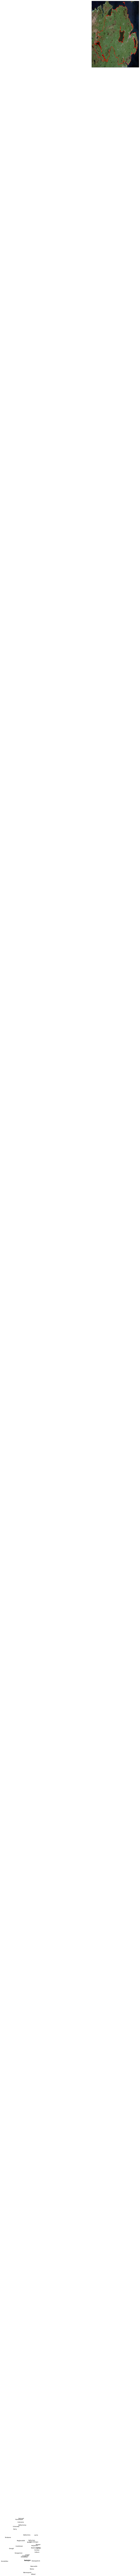

In [43]:
# seperate towns and cities
towns_sep = towns[towns['STATUS'] == 'Town']
cities_sep = towns[towns['STATUS'] == 'City']

# plot towns and cities with different colours
towns_sep.plot(ax=ax, color='gray', marker='^', label='Town', markersize=50)
cities_sep.plot(ax=ax, color='blue', marker='o', label='City', markersize=100)

# add labels for town/city names
for idx, row in towns_sep.iterrows():
    ax.text(row['X_COORD'], row['Y_COORD'], row['TOWN_NAME'], fontsize=9, ha='right', color='black')

for idx, row in cities_sep.iterrows():
    ax.text(row['X_COORD'], row['Y_COORD'], row['TOWN_NAME'], fontsize=9, ha='left', color='black')

fig

In [44]:
# finally, try to add a transparent overlay to the map
# note: one way you could do this is to combine the individual county shapes into a single shape, then
# use a geometric operation, such as a symmetric difference, to create a hole in a rectangle.
# then, you can add the output of the symmetric difference operation to the map as a semi-transparent feature.

C:\Users\byg-l\anaconda\envs\egm722\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\Users\byg-l\anaconda\envs\egm722\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')


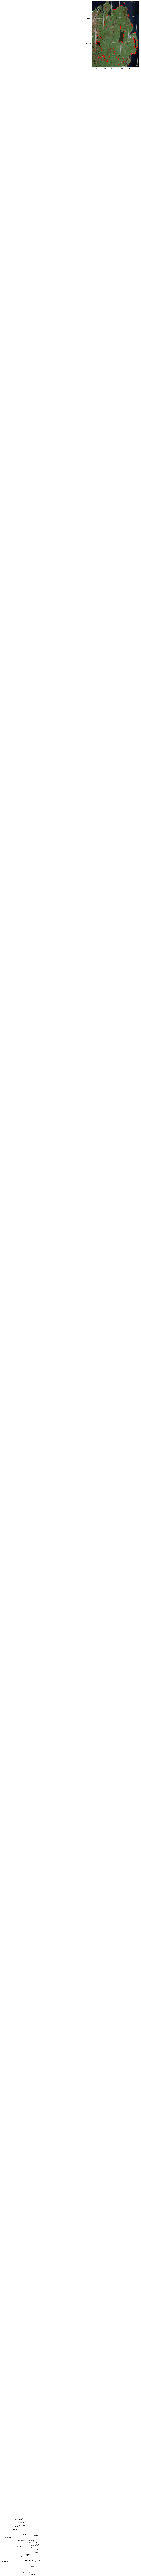

In [45]:
# last but not least, add gridlines to the map
gridlines = ax.gridlines(draw_labels=True, # draw  labels for the grid lines
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5], # add longitude lines at 0.5 deg intervals
                         ylocs=[54, 54.5, 55, 55.5]) # add latitude lines at 0.5 deg intervals
gridlines.top_labels = False
gridlines.right_labels = False

fig

In [46]:
# and of course, save the map!
fig.savefig('w4_map.png', bbox_inches='tight', dpi=300)

C:\Users\byg-l\anaconda\envs\egm722\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
C:\Users\byg-l\anaconda\envs\egm722\Lib\site-packages\cartopy\mpl\feature_artist.py:173: UserWarning: Unable to determine extent. Defaulting to global.
  warnings.warn('Unable to determine extent. Defaulting to global.')
